# Construct school interaction networks from basic school statistics

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import construct_school_network as csn

from importlib import reload

# for progress bars
from ipywidgets import IntProgress
from IPython.display import display
import time

## Background information

### Descriptive school constants

Descriptive school statistics are inspired by [data](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html) about Austrian schools from 2018.

In [653]:
# different age structures in Austrian school types
age_brackets = {'primary':[6, 7, 8, 9],
                'primary_dc':[6, 7, 8, 9],
                'lower_secondary':[10, 11, 12, 13],
                'lower_secondary_dc':[10, 11, 12, 13],
                'upper_secondary':[14, 15, 16, 17],
                'secondary':[10, 11, 12, 13, 14, 15, 16, 17],
                'secondary_dc':[10, 11, 12, 13, 14, 15, 16, 17]
               }

In [568]:
school_characteristics = {
    # Volksschule: Schulen: 3033, Klassen: 18245, Schüler*innen: 339382
    'primary':  {'classes':8, 'students':19, 'floors':1},
    'primary_dc':  {'classes':8, 'students':19, 'floors':1},
    # Hauptschulen: 47, Klassen 104, Schüler*innen: 1993
    # Neue Mittelschule: Schulen 1131, Klassen: 10354, Schüler*innen: 205905
    # Sonderschulen: 292, Klassen: 1626, Schüler*innen: 14815
    # Polytechnische Schulen: nur Schulstufe 9, ignorieren
    # AHS Unterstufe: Schulen: 281, Klassen: 4901, Schüler*innen: 119591
    # Berufsbildende mittlere Schulen: 381, Klassen: 1981, Schüler*innen: 44048
    # Gesamt: Schulen: 2132, Klassen: 18966, Schüler*innen: 386352
    'lower_secondary':   {'classes':10, 'students':20, 'floors':1},
    'lower_secondary_dc':   {'classes':10, 'students':20, 'floors':1},
    # AHS Obserstufe: Schulen: 348, Klassen: 4119, Schüler*innen: 92193
    # Berufsbildende höhere Schulen: 353, Klassen: 6061, Schüler*innen: 143544
    # Berufsschulen: Schulen: 154, Klassen 6187, Schüler*innen: 114493
    # Gesamt: Schulen: 855, Klassen 16367, Schüler*innen: 350230
    'upper_secondary':    {'classes':20, 'students':21, 'floors':1},
    # Oberstufenrealgymnasien: Schulen: 114, Klassen: 1183, Schüler*innen 26211
    # Aufbaugymnasiuen: Schulen: 4, Klassen: 27, Schüler*innen: 601
    # Gesamt: 118, Klassen: 1210, Schüler*innen: 26812 
    'secondary':    {'classes':10, 'students':22, 'floors':1}
}

### Characteristics of Austrian families

Family sizes with children < 18 years old from the [Austrian microcensus 2019](https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/haushalte_familien_lebensformen/familien/index.html) (Note: 63.45 % of all households have no children), file ```familien_nach_familientyp_und_zahl_der_kinder_ausgewaehlter_altersgruppen_```:

* 1 child: 48.15 % (81.95 % two parents, 18.05 % single parents)
* 2 children: 38.12 % (89.70 % two parents, 10.30% single parents)
* 3 children: 10.69 % (88.26 % two parents, 11.74 % single parents)
* 4 or more children: 3.04 % (87.44 % two parents, 12.56 % single parents)

In [569]:
# given the precondition that the family has at least one child, how many
# children does the family have?
p_children = {1:0.4815, 2:0.3812, 3:0.1069, 4:0.0304}

# probability of being a single parent, depending on the number of children
p_parents = {1:{1:0.1805, 2:0.8195},
             2:{1:0.1030, 2:0.8970},
             3:{1:0.1174, 2:0.8826},
             4:{1:0.1256, 2:0.8744}
            }

General household sizes of households with one family (2.51% of households have more than one family) [Austrain household statistics 2019](https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/haushalte_familien_lebensformen/haushalte/index.html), files 
* ```ergebnisse_im_ueberblick_privathaushalte_1985_-_2019```
* ```familien_nach_familientyp_und_zahl_der_kinder_ausgewaehlter_altersgruppen_``` 

Percentages:
* single $\frac{(3950 - 2388)}{3959}$ = 39.54 %
* couple, no kids $\frac{1001}{3959}$ = 25.28 % 
* 4.44 % single parent with one kid < 18 = 277/3950 * 87.0/137.4
* 1.90 % single parent with two kids < 18 = 277/3950 * 37.3/137.4
* 0.67 % single parent with three or more kids < 18 = 277/3950 * 13.1/137.4
* 11.06 % couples with one kid < 18 = 1050 / 3950 * 252.4 / 606.7
* 11.19 % couples with two kids < 18 1050 / 3950 * 255.5 / 606.7
* 4.33 % couples with three or more kids <18 1050 / 3950 * 98.9 / 606.7
* 1.59 % households with three adults (statistic: household with  kids > 18 years)

In [249]:
# probability of a household having a certain size, independent of having a child
teacher_p_adults = {1:0.4655, 2:0.5186, 3:0.0159}
teacher_p_children = {1:{0:0.8495, 1:0.0953, 2:0.0408, 3:0.0144},
                      2:{0:0.4874, 1:0.2133, 2:0.2158, 3:0.0835},
                      3:{0:1, 1:0, 2:0, 3:0}}

### Mask wearing & link type  to contact type mapping

In [250]:
# Note: student_student_daycare overwrites student_student_intra_class
contact_map = {
    'student_household':{True:'close', False:'close'}, # no-mask setting
    'student_student_friends':{True:'intermediate', False:'intermediate'}, # no-mask setting, not implemented
    'student_student_intra_class':{True:None, False:'far'}, # only student masks are important
    'student_student_table_neighbour':{True:'far', False:'intermediate'}, # only student masks are important
    'student_student_daycare':{True:'far', False:'intermediate'},
    'teacher_household':{True:'close', False:'close'}, # no-mask setting
    'teacher_teacher_short':{True: None, False:'far'}, # only teacher masks are important
    'teacher_teacher_long':{True:'far', False:'intermediate'}, # only teacher masks are important
    'teacher_teacher_team_teaching':{True:'far', False:'intermediate'}, # only teacher masks are important
    'teacher_teacher_daycare_supervision':{True:'far', False:'intermediate'}, # only teacher masks are important
    'teaching_teacher_student':{True:'far', False:'intermediate'}, # both teacher and student masks are important
    'daycare_supervision_teacher_student':{True:'far', False:'intermediate'}, # both teacher and student masks are important
}

### Teacher social contacts

Network density scores from an [article about interactions between teachers](https://academic.oup.com/her/article/23/1/62/834723?login=true) for "socialize with outside of school" (```r_friend```) and "engage in conversation regularly" (```r_conversation```).

In [251]:
r_teacher_friend = 0.059
r_teacher_conversation = 0.255

## Compose calibration schools

Characteristics of the "average" school, depending on school type. These characteristics were determined in interviews with Austrian teachers and from [statistics about Austrian schools](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html) (year 2017/18, page 10).  
**NOTE**: "students" indicates the number of students per class.  

In [252]:
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']
school_types = ['primary_dc', 'primary', 'lower_secondary', 'lower_secondary_dc']
student_mask = False
teacher_mask = False

In [260]:
reload(csn)
for school_type in school_types:
    N_classes = school_characteristics[school_type]['classes']
    class_size = school_characteristics[school_type]['students']
    N_floors = school_characteristics[school_type]['floors']
    school_name = '{}_classes-{}_students-{}_floors-{}'.format(school_type,\
                N_classes, class_size, N_floors)
    age_bracket = age_brackets[school_type]
    
    G, teacher_schedule, student_schedule = csn.compose_school_graph(\
                school_type, N_classes, class_size, 
                N_floors, age_bracket, p_children, p_parents, teacher_p_adults,
                teacher_p_children, r_teacher_conversation, r_teacher_friend)

    csn.map_contacts(G, student_mask, teacher_mask, contact_map)
                                          
    nx.readwrite.gpickle.write_gpickle(G, \
    '../data/school/calibration_schools/{}.gpickle'.format(school_name))

    # extract node list
    node_list = csn.get_node_list(G)
    node_list.to_csv('../data/school/calibration_schools/{}_node_list.csv'
                        .format(school_name), index=False)

    # format schedule
    for schedule, agent_type in zip([teacher_schedule, student_schedule], ['teachers', 'students']):
        schedule.to_csv('../data/school/calibration_schools/{}_schedule_{}.csv'
                            .format(school_name, agent_type), index=False)
                    

## Compose all schools

In [7]:
class_sizes = [10, 15, 20, 25, 30,]
class_numbers = [4, 6, 8, 10, 14, 20, 24, 30, 40, 50, 70, 100]
floor_numbers = [1, 2, 3, 4]
school_types = ['primary', 'primary_dc', 'lower_secondary', 'lower_secondary_dc',
                'upper_secondary', 'secondary']

In [8]:
f = IntProgress(min=0, max=len(school_types) * len(class_sizes) \
                       * len(class_numbers) * len(floor_numbers)) 
display(f)
c=0 # counter for progress bar

# number of inter-class contacts for neighboring classes:
# as each class has cross_class_contacts to each of it's N_close_classes 
# neighbours, the total number of inter-class contacts between each pair of 
# neighboring classes is X*Y
cross_class_contacts = 0

for school_type in school_types:
    age_bracket = age_brackets[school_type]
    for N_classes in class_numbers:
        for class_size in class_sizes:
            for N_floors in floor_numbers:
                f.value = c # update the progress bar
                c += 1
                
                school_name = '{}_classes-{}_students-{}_floors-{}'\
                    .format(school_type, N_classes, class_size, N_floors)
                
                # compose contact network
                try:
                    G, schedule = csn.compose_school_graph(school_type,
                        N_classes, class_size, N_floors,age_bracket, 
                        family_sizes, N_hours, cross_class_contacts, 
                        'post_lockdown')
                    
                    nx.readwrite.gpickle.write_gpickle(G, \
                    '../data/school/networks/{}.gpickle'.format(school_name))

                    # extract node list
                    node_list = csn.get_node_list(G)
                    node_list.to_csv('../data/school/node_lists/{}_node_list.csv'
                                        .format(school_name), index=False)

                    # format schedule
                    schedule = csn.get_schedule(schedule)
                    schedule.to_csv('../data/school/schedules/{}_schedule.csv'
                                        .format(school_name))
                    
                except AssertionError:
                    pass

IntProgress(value=0, max=2640)

TypeError: compose_school_graph() missing 2 required positional arguments: 'teacher_contacts_intermediate' and 'time_period'

## Compose and visualize a sample graph

In [9]:
# number of students in a class
class_size = 10
# number of classes in a school
N_classes = 20
# architecture
N_floors = 1
# school type
school_type = 'primary'
age_bracket = age_brackets[school_type]

In [36]:
reload(csn)

# number of teaching units / day
N_hours = 8
# number of inter-class contacts for neighboring classes:
# as each class has cross_class_contacts to each of it's N_close_classes 
# neighbours, the total number of inter-class contacts between each pair of 
# neighboring classes is X*Y
N_cross_class_contacts = 0
# number of other teachers each teacher has fleeting contact with every day
N_teacher_contacts_far = 10
# number of teachers a teacher has intermediate contacts with every day
N_teacher_contacts_intermediate = 2
# if time-period == 'calibration', networks without household-members are generated
# if time-period == 'post-lockdown', networks with post-lockdown contact
# configurations (i.e. student close contacts only to table neighbours) are
# generated
time_period = 'calibration'

G, schedule = csn.compose_school_graph(school_type, N_classes, class_size,
        N_floors, age_bracket, family_sizes, N_hours, N_cross_class_contacts, 
        N_teacher_contacts_far, N_teacher_contacts_intermediate, 'calibration')

#school_name = '{}_classes-{}_students-{}_floors-{}'\
#    .format(school_type, N_classes, class_size, N_floors)
school_name = 'test_volksschule'

nx.readwrite.gpickle.write_gpickle(G, '../data/school/{}.gpickle'.format(school_name))

node_list = csn.get_node_list(G)
node_list.to_csv('../data/school/{}_node_list.csv'
                    .format(school_name), index=False)

schedule = csn.get_schedule(schedule)
schedule.to_csv('../data/school/{}_schedule.csv'
                    .format(school_name), index=False)

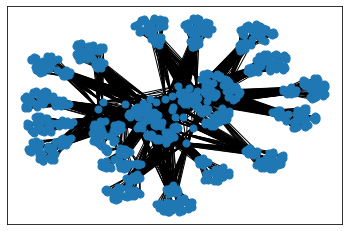

In [37]:
infection_risk_contact_type_weights={
            'very_far': 0.1, 'far': 0.1, 'intermediate': 5, 'close': 3}

for e in G.edges(data=True):
    G[e[0]][e[1]]['weight'] = infection_risk_contact_type_weights\
        [G[e[0]][e[1]]['contact_type']]

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_size=50, with_labels=False)

### Visualization

#### Create fixed node positions for students and teachers

In [7]:
fixed_pos = {}
class_width = 0.2
class_x_sep = 0.2/3
class_height = 0.2
N_horizontal = 5
N_vertical = 4

# bottom row of classes
student_counter = 1
for c in range(0, 4):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * c + x * class_width / N_horizontal + \
                c * class_x_sep
            y_pos = 0 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1

# left middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = 0 + x * class_width / N_horizontal
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1
        
# right middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = class_width * 3 + x * class_width / N_horizontal + \
            3 * class_x_sep
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1

# top row of classes
for c in range(7, 11):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * (c-7) + x * class_width / N_horizontal +\
                (c - 7) * class_x_sep
            y_pos = 0.6 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1
            
# teachers
teacher_counter = 1
for x in range(0, N_horizontal):
    for y in range(0, N_vertical):
        x_pos = class_width * 1.5 + x * class_width / N_horizontal + \
            1 * class_x_sep
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'t{}'.format(teacher_counter):(x_pos, y_pos)})
        teacher_counter += 1

#### Visualize the class

In [14]:
N_teachers = N_classes * 2
students = node_list[node_list['type'] == 'student']['ID'].values
teachers = node_list[node_list['type'] == 'teacher']['ID'].values
family_members = node_list[node_list['type'] == 'family_member']['ID'].values

(-0.3, 1.3)

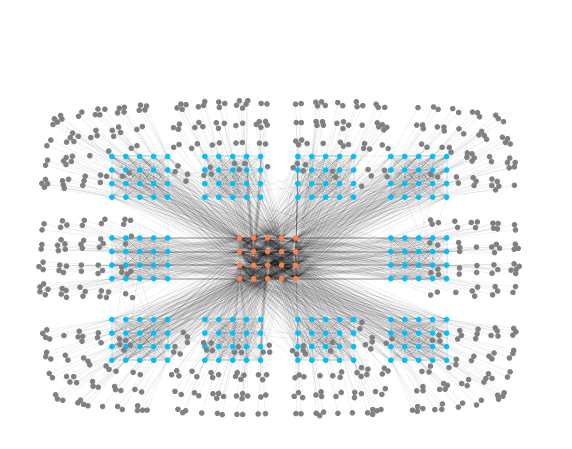

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
# generate random positions for family members (students & teachers are fixed)
pos = nx.spring_layout(G, pos=fixed_pos, fixed=fixed_pos.keys())

node_color = ['DeepSkyBlue'] * len(students)
node_color.extend(['Coral'] * len(teachers))
node_color.extend(['grey'] * len(family_members))

all_nodes = node_list['ID'].values

nx.draw(G, pos, node_size=20, ax=ax, width = 0.05, nodelist=all_nodes, \
       node_color = node_color)
ax.set_ylim(-0.3, 1.3)
ax.set_xlim(-0.3, 1.3)

## Testing

### Graph generation

In [839]:
# number of students in a class
class_size = 20
# number of classes in a school
N_classes = 10
# architecture
N_floors = 1
# school type
school_type = 'secondary_dc'
age_bracket = age_brackets[school_type]
student_mask = False
teacher_mask = False

In [840]:
reload(csn)
G, teacher_schedule, student_schedule = csn.compose_school_graph(school_type, N_classes, class_size, 
                N_floors, p_children, p_parents, teacher_p_adults,
                teacher_p_children, r_teacher_conversation, r_teacher_friend)

csn.map_contacts(G, student_mask, teacher_mask, contact_map)

node_list = csn.get_node_list(G)

### Graph visualization

In [841]:
fixed_pos = {}
class_width = 0.2
class_x_sep = 0.2/3
class_height = 0.2
N_horizontal = 5
N_vertical = 4

N_teachers = csn.get_N_teachers(school_type, N_classes)

# bottom row of classes
student_counter = 1
for c in range(0, 4):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * c + x * class_width / N_horizontal + \
                c * class_x_sep
            y_pos = 0 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1

# left middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = 0 + x * class_width / N_horizontal
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1
        
# right middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = class_width * 3 + x * class_width / N_horizontal + \
            3 * class_x_sep
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1

# top row of classes
for c in range(7, 11):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * (c-7) + x * class_width / N_horizontal +\
                (c - 7) * class_x_sep
            y_pos = 0.6 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1
            
# teachers
teacher_counter = 1
for x in range(0, N_horizontal):
    for y in range(0, N_vertical):
        x_pos = class_width * 0.5 + x * class_width * 2.75 / N_horizontal + \
            1 * class_x_sep * 2.5
        y_pos = 0.225 + y * class_height * 2 / N_vertical
        fixed_pos.update({'t{}'.format(teacher_counter):(x_pos, y_pos)})
        teacher_counter += 1
        if teacher_counter > N_teachers:
            break
    if teacher_counter > N_teachers:
        break

In [842]:
students = node_list[node_list['type'] == 'student']['ID'].values
teachers = node_list[node_list['type'] == 'teacher']['ID'].values
family_members = node_list[node_list['type'] == 'family_member']['ID'].values

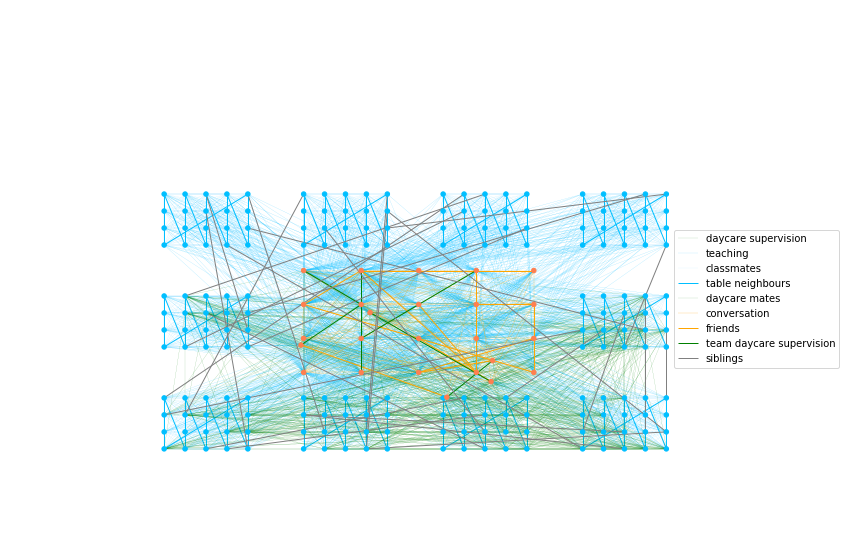

In [843]:
fig, ax = plt.subplots(figsize=(15, 10))
# generate random positions for family members (students & teachers are fixed)
pos = nx.spring_layout(G, pos=fixed_pos, fixed=fixed_pos.keys())

node_color = ['DeepSkyBlue'] * len(students)
node_color.extend(['Coral'] * len(teachers))
#node_color.extend(['grey'] * len(family_members))

all_nodes = list(students)
all_nodes.extend(list(teachers))
#all_nodes.extend(list(family_members))

nx.draw(G, pos, node_size=20, ax=ax, width = 0, nodelist=all_nodes, \
       node_color = node_color)

# daycare: green
# teaching: blue
# siblings: grey
# teacher social contacts: orange

# teacher <-> student links
edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == 'daycare_supervision_teacher_student']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=0.1, edge_color='green', label='daycare supervision')
edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == 'teaching_teacher_student']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=0.1, edge_color='DeepSkyBlue', label='teaching')

# student <-> student links
edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == 'student_student_intra_class']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=0.05, edge_color='DeepSkyBlue', label='classmates')
edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == 'student_student_table_neighbour']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=1, edge_color='DeepSkyBlue', label='table neighbours')
edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == 'student_student_daycare']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=0.1, edge_color='green', label='daycare mates')

# teacher <-> teacher links
edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == 'teacher_teacher_short']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=0.2, edge_color='orange', label='conversation')
edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == 'teacher_teacher_long']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=1, edge_color='orange', label='friends')
edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == 'teacher_teacher_team_teaching']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=1, edge_color='blue', label='team teaching')
edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == 'teacher_teacher_daycare_supervision']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=1, edge_color='green', label='team daycare supervision')

edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['contact_type'] == 'close' and \
                                                       G.nodes[u]['type'] == 'student' and \
                                                       G.nodes[v]['type'] == 'student']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=1, edge_color='grey', label='siblings')
ax.legend(bbox_to_anchor=[1, 0.6, 0, 0])

ax.set_ylim(-0.3, 1.3)
ax.set_xlim(-0.3, 1.3)

plt.savefig('../img/{}_contact_visualization.pdf'.format(school_type))

In [824]:
teacher_schedule

,teacher,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8
0,t1,1,9,NaN,7,NaN,NaN,5,NaN
1,t2,2,10,NaN,8,NaN,NaN,6,NaN
2,t3,3,NaN,1,9,NaN,NaN,7,NaN
3,t4,4,NaN,2,10,NaN,NaN,8,NaN
4,t5,5,NaN,3,NaN,1,NaN,9,NaN
5,t6,6,NaN,4,NaN,2,NaN,10,NaN
6,t7,7,NaN,5,NaN,3,NaN,NaN,1
7,t8,8,NaN,6,NaN,4,NaN,NaN,2
8,t9,9,NaN,7,NaN,5,NaN,NaN,3
9,t10,10,NaN,8,NaN,6,NaN,NaN,NaN


In [826]:
csn.get_N_teachers('upper_secondary', N_classes)

28

### Family sizes

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# students
family_sizes = []
student_families = [n[1]['family'] for n in G.nodes(data=True) \
                    if n[1]['type'] == 'student']
for f in student_families:
    fsize = [n for n in G.nodes(data=True) if n[1]['family'] == f]
    family_sizes.append(len(fsize))
    
axes[0].hist(family_sizes, bins=range(1, 9), rwidth=0.8, align='left', density=True)
axes[0].set_xlabel('household size')
axes[0].set_ylabel('density')
axes[0].set_title('household size distribution in\nstudent families')

# teachers
family_sizes = []
teacher_families = [n[1]['family'] for n in G.nodes(data=True) \
                    if n[1]['type'] == 'teacher']
for f in teacher_families:
    fsize = [n for n in G.nodes(data=True) if n[1]['family'] == f]
    family_sizes.append(len(fsize))
    
axes[1].hist(family_sizes, bins=range(1, 9), rwidth=0.8, align='left', density=True)
axes[1].set_xlabel('household size')
axes[1].set_ylabel('density')
axes[1].set_title('household size distribution in\nfamilies of teachers');

### Connection statistics between classes

Text(0.5, 1.0, 'different classes')

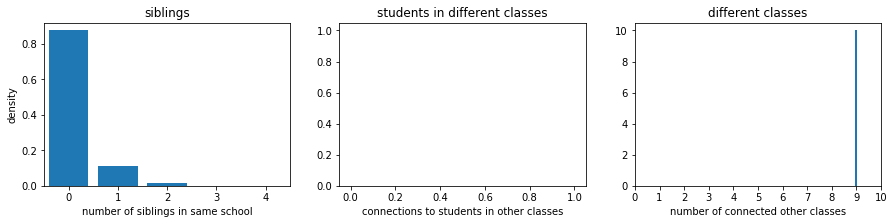

In [146]:
# number of siblings
siblings = []
for s in students:
    family = G.nodes[s]['family']
    tmp_siblings = [n[0] for n in G.nodes(data=True) if \
                (n[1]['family'] == family and n[1]['type'] == 'student')]
    
    siblings.append(len(tmp_siblings) - 1)
    
# number of connections between classes
connected_other_students = []
connected_other_classes = []

for c in range(1, N_classes + 1):
    students_in_class = [n[0] for n in G.nodes(data=True) if n[1]['type'] == 'student' \
                        and n[1]['unit'] == 'class_{}'.format(c)]
    
    tmp_connected_other_students = []
    tmp_connected_other_classes = []
    for s in students_in_class:
        for n in G[s]:
            if n not in students_in_class and n.startswith('s'):
                tmp_connected_other_students.append(n)
                tmp_connected_other_classes.append(G.nodes[n]['unit'])
                
    connected_other_students.append(len(tmp_connected_other_students))
    connected_other_classes.append(len(set(tmp_connected_other_classes)))
        
fig, axes = plt.subplots(1, 3, figsize=(15,3))
axes[0].hist(siblings, bins=range(0, 5), rwidth=0.8, align='left', density=True)
axes[0].set_xticks(range(0, 5))
axes[0].set_xlim(-0.5, 4.5)
axes[0].set_ylabel('density')
axes[0].set_xlabel('number of siblings in same school')
axes[0].set_title('siblings')

axes[1].hist(connected_other_students, bins=range(0, 11), rwidth=0.8,
             density=True, align='left')
axes[1].set_xticks(range(0, 11))
axes[1].set_xlabel('connections to students in other classes')
axes[1].set_title('students in different classes')


axes[2].hist(connected_other_classes, bins=range(0, 11), rwidth=0.8,
             density=True, align='left')
axes[2].set_xticks(range(0, 11))
axes[2].set_xlabel('number of connected other classes')
axes[2].set_title('different classes')

In [144]:
connected_other_students

[162, 224, 189, 173, 145, 144, 158, 153, 207, 185]

### Connection statistics between teachers

Text(0.5, 1.0, 'long contacts')

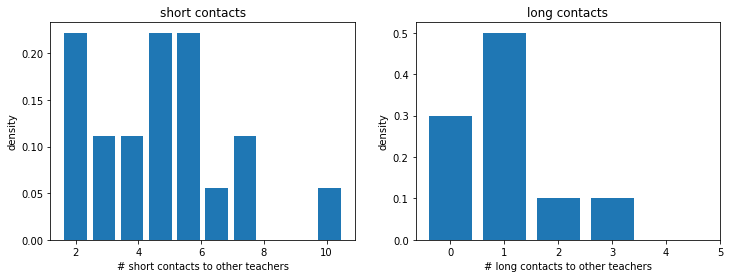

In [22]:
teacher_teacher_short = []
teacher_teacher_long = []
for t1 in G.nodes(data=True):
    long = 0
    short = 0
    if t1[1]['type'] == 'teacher':
        connected_teachers = [n for n in G[t1[0]] if n.startswith('t')]
        for t2 in connected_teachers:
            if G[t1[0]][t2]['link_type'] == 'teacher_teacher_short':
                short += 1
            if G[t1[0]][t2]['link_type'] == 'teacher_teacher_long':
                long += 1
        teacher_teacher_short.append(short)
        teacher_teacher_long.append(long)
        
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(teacher_teacher_short, rwidth=0.8, density=True, align='left')
axes[0].set_xlabel('# short contacts to other teachers')
axes[0].set_ylabel('density')
axes[0].set_title('short contacts')

axes[1].hist(teacher_teacher_long, rwidth=0.8, density=True, align='left',
            bins=range(0, 6))
axes[1].set_xticks(range(0, 6))
axes[1].set_xlabel('# long contacts to other teachers')
axes[1].set_ylabel('density')
axes[1].set_title('long contacts')

## School types

### Primary schools

#### The average primary school
Austrian primary schools are compulsory for children above the age of 6 and offer education according to [ISCED level 1](https://en.wikipedia.org/wiki/International_Standard_Classification_of_Education). Austrian primary schools have 4 levels, therefore students in Austrian primary schools are typically aged between 6 and 10. According to the Austrian education statistics of the year 2017/18, there are 3033 Primary schools with a total of 18,245 classes and 339,382 students in Austria. Therefore the average Austrian primary school has 8 classes with 19 students each, corresponding to two classes per level. 

#### Full-day-care
About [50% of primary schools in Austria](file:///home/jana/Documents/Factsheets_Pflichtschule%20und%20Tagesbetreuung_20200123.pdf) offer full-day-care and about [25% of students in primary schools](file:///home/jana/Documents/Factsheets_Pflichtschule%20und%20Tagesbetreuung_20200123.pdf) participate in full-day-care. Full-day-care is organised in two different models: integrated and separated. In the separated model, teaching ends after 4-5 hours every day and is followed by supervised lunch, work on homework and other activities for another 3-4 hours.  Since usually not all students of a school participate in the full-day-care in the separated model, classes are broken up after the teaching part of the day and students are re-distributed into a number of groups that is usually smaller than the number of classes the school has. In the integrated model, teaching is intertwined with other activities and supervised work on homework. In this model, all students participate in the full-day-care and classes are not broken up. [Of the schools that offer full-day-care, 95%]( https://www.bmbwf.gv.at/Themen/schule/schulsystem/gts/ba_standorte.html) run the separated model. To approximate these numbers, we assume that 50% of schools in our primary school ensemble offer full-day-care in which 50% of the children in these schools participate, respectively. We only model separated full-day-care, since this corresponds to the vast majority of Austrian primary schools. For afternoon supervision, students are re-organised into groups of the same size as the morning classes by randomly selecting 50% of the total number of students and randomly assigning them to M groups, where M=N/2 and N is the number of classes. 

#### Syllabus & teaching personnel
According to the [syllabus](https://www.bmbwf.gv.at/dam/jcr:f4f200c0-b999-42c8-9dba-1ca18fa89e14/lp_vs_vierter_teil_14042.pdf) for Austrian primary schools, Austrian kids spend between 20 and 25 hours at school every week. Out of this total amount of hours, 11 hours are spent learning primary subjects (reading, writing, math, information retrieval), the other hours are spent learning minor subjects (sports, religion, creative subjects). We approximate this syllabus in the following way: Children in our simulated primary schools spend 20 hours / week or 4 hours / day at school. Every day, the first two hours are allotted to learning primary subjects, whereas the rest of the day is alloted to secondary subjects. Primary subjects are all taught by a single teacher for every class, respectively ("class teacher"), whereas secondary subjects are taught by different teachers. 

According to the [financing regulations for Austrian primary schools](file:///home/jana/Documents/Factsheets_Pflichtschule%20und%20Tagesbetreuung_20200123.pdf), 1.5 teachers / class are financed in Austrian schools. Nevertheless, this number does not include staff needed for additional offers such as full-day-care, language classes or religion classes. According to the Austrian school statistics 2017/18, the [total number of teachers in primary schools](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd/lehrstat_oester.html) was 33050, whereas the [number of classes was](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html) 18245, yielding an average of 1.81 teachers per class. Unfortunately, this number cannot be stratified for schools with and without full-day-care. This number also only reflects the number of full-time equivalents alloted for teaching and not the true number of persons that are involved in teaching, which might be higher if a share of teachers only works part-time. According the structured interview we conducted with a director of a primary school offering full-day-care, the number of teachers was 14 for a school with 6 classes, yielding an average of 2.3 teachers per class. Since the primary school we interviewed offered full-day-care organised into 4 afternoon supervision groups, this number included personnel to supervise students in the afternoon. 

To approximate this situation, we model schools without full-day-care to have 1.5 teachers per class, and each teacher has contact to a total of two different classes (every day, but also over the course of the week). The low number of classes reflects the fact that teaching in primary schools is still largely organized around a focal class teacher that teaches the same class for extended periods of time in several primary subjects. We model schools with full-day-care to have 2 teachers per class, where each teacher still has contact to a total of two different classes, and half of the teachers supervise an afternoon care group in addition to teaching. 

### Lower secondary schools

#### School types
Lower secondary schools offer education according to [ISCED level 2](https://en.wikipedia.org/wiki/International_Standard_Classification_of_Education) and teach children aged 11 to 14. In Austria, there are two main school types that offer this type of education:
* **Sonderschule**: 292 schools, 1626 classes, 14815 students
* **Mittelschule**: 1178 schools, 10458 classes, 207943 students
We note that for the type "Mittelschule" the numbers that are reported in the latest statistics from the year 2017/18 for the types "Hauptschule" (47 schools) and "Neue Mittelschule" (1131 schools) were combined, since the Hauptschule was out by September 2020 and replaced the Mittelschule.  

Another school type that offers ISCED level 2 education in Austria is the **AHS Unterstufe** (281 schools, 4901 classes, 119591 students), which usually is combined with an **AHS Oberstufe** that offers ISCED level 3 education. These combined schools are modelled separately and described below.

#### Daycare
In these school types about 50% of schools offer daycare of children in the afternoons: Mittelschule (18% of childrenin daycare) and Sonderschule (28% of children in daycare), class-weighted average 19%. Therefore in the schools that do offer daycare, on average 38% of students are in daycare (a bit less then in primary schools, where the ratio is 50%). Similar to primary schools, the vast majority of these schools run the separated model and we model the daycare similarly. We therefore model these schools similarly to schools offering primary education when it comes to daycare: We construct an ensemble of schools where 50% of schools offer daycare. In the schools that do offer daycare, 

In [471]:
weighted_average = \
10354 / (10354 + 1626) * 0.18 + 1626 / (10354 + 1626) * 0.28
print('weighted average % children in daycare: {:1.2f}'.format(weighted_average))

weighted average % children in daycare: 0.19


#### Syllabus and teaching personnel
According to the [syllabus](https://www.ris.bka.gv.at/GeltendeFassung.wxe?Abfrage=Bundesnormen&Gesetzesnummer=20007850), students in the Mittelschule spend an average of 30 hours / week or 6 hours / day at school. The syllabus includes on average 12 different subjects per school year (some subjects are not taught in all years). According to the [syllabus](https://www.ris.bka.gv.at/Dokumente/BgblAuth/BGBLA_2008_II_137/COO_2026_100_2_440355.html) of the Sonderschule, children spend a bit less time (on average 28 hours / week) in these schools, the number of subjects is the same as in the other lower secondary school types.  

According to the [statistics for the school year 2017/18](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html) the number of teachers per class in lower secondary schools is higher than in primary schools, since there are more subjects and no dedicated class teachers anymore. Sonderschulen have the highest number of teachers / class (3.4) followed by Mittelschulen (2.8). The average number of teachers / class in lower secondary education (weighted by the number of classes) is 2.87. Among the schools we interviewed, there were two MS, one with 15 classes, 36 teachers (excluding daycare personnel) and 2.4 teachers / class), and one with 16 classes, 50 teachers (including daycare personnel) and 3.1 teachers / class. Both of these schools offered daycare. Sadly, we cannot differentiate between schools that offer daycare and schools that don't in the Austria-wide statistics. Given the numbers from the Austria-wide statistics and our interviews, we think it is warranted to assume lower secondary schools with daycare employ 3 teachers / class, whereas schools without daycare employ 2.5 teachers / class.  

In [473]:
sonderschule_teachers = 5502
sonderschule_classes = 1626
print('Sonderschule teachers / class: {:1.2f}'.format(sonderschule_teachers / sonderschule_classes))

MS_classes = 10354 + 104
MS_teachers = 29165
print('Mittelschule + Hauptschule teachers / class: {:1.2f}'.format(MS_teachers / MS_classes))


weighted_average = \
1626 / (1626 + 10353 + 104) * 3.3837638376383765 + \
10458 / (1626 + 10353 + 104) * 2.788774144195831

print('weighted average: {:1.2f}'.format(weighted_average))

Sonderschule teachers / class: 3.38
Mittelschule + Hauptschule teachers / class: 2.79
weighted average: 2.87


For the school type Mittelschule, team-teaching has become the norm in Austria. This means that for the majority of classes (according to our interviews 4/6 to 5/6 of lessons), two teachers are present during a lesson. This obviously introduces additional contacts between the teachers that teach lessons together. In Sonderschulen it is also customary to have additional supporting personnel present to support students with special needs. We therefore model schools that teach lower secondary grades to have a large share of team-teaching: for schools without daycare, 4 out of 6 lessons every day are team-taught lessons. For schools with daycare, 5 out of 6 lessons every day are team-taught lessons.

In [474]:
print('% students in Mittelschule: {:1.2f}'.format(205905 / (14815 + 205905)))
print('% classes in Mittelschule: {:1.2f}'.format(10458 / (10458 + 1626)))
print('% schools in Mittelschule: {:1.2f}'.format(1178 / (281 + 1178)))

% students in Mittelschule: 0.93
% classes in Mittelschule: 0.87
% schools in Mittelschule: 0.81


### Upper secondary schools

#### School types
Upper secondary schools offer education according to [ISCED level 3](https://en.wikipedia.org/wiki/International_Standard_Classification_of_Education) and teach children aged 15 to 18. In Austria, there are a two main types of schools that offer upper ISCED level 3 education :
* **Oberstufenrealgymnasium**: 114 schools, 1183 classes, 26211 students
* **Berufsbildende mittlere & höhere Schulen**: 381 + 353  = 734 schools, 1981 + 6061 = 8042 classes, 44048 + 143544 = 187592 students.

There is also the **AHS Oberstufe**, which offers ISCED level 3 education in combination with the AHS Unterstufe (level 2 education) and is modeled separately and described below. In addition, there are the polytechnischen Schulen, which only offer education for the 9th grade (students aged ~15). There are a total of 237 polygechnische Schulen with 764 classes and 15309 students. Compared to the other two school types, only a minor share of students aged 15-18 attend these schools (7%). We therefore chose to not model this school type separately.

None of the upper secondary education school type offer any daycare after lessons end.

In [476]:
print('% students in polytechnische Schule: {:1.2f}'.format(15309 / (187592 + 26211 + 15309)))
print('% classes in polytechnische Schule: {:1.2f}'.format(764 / (8042 + 1183 + 764)))
print('% schools of type polytechnische Schule: {:1.2f}'.format(237 / (734 + 114 + 237)))

% students in polytechnische Schule: 0.07
% classes in polytechnische Schule: 0.08
% schools of type polytechnische Schule: 0.22


#### Syllabus and teaching personnel
Oberstufenrealgymnasien have the same syllabus as the AHS Oberstufe and are in general similar to the AHS Oberstufe. The only difference is that this schools do not offer lower secondary education. Nevertheless, we choose to model the Oberstufenrealgymnasium separately from the Allgemeinbildende höhere Schulen (AHS Unterstufe + AHS Oberstufe) since we think that the different age structure of the student population in these schools (only students aged 15-18 instead of students aged 11-18) warrants a different treatment. According to the [syllabus of the AHS Oberstufe](https://www.ris.bka.gv.at/GeltendeFassung.wxe?Abfrage=Bundesnormen&Gesetzesnummer=10008568), students have an average of 32.5 hours / week at of lessons at school. In addition, there are a number of non-mandatory tutorials, longer breaks and vocational activities that students engage in. In summary, we model the students to spend 8 hours / day at school. 

Sadly, the Austria wide school statistics does not show the number of teachers per class stratified for Oberstufenrealgymnasium. Since these schools are similar to the AHS Oberstufe, we use the number of teachers / class for the AHS Obserstufe, which have on average 2.5 teachers / class. The berufsbildende mittlere & höhere Schulen have on average 2.9 teachers / class. The average weighted by the number of classes of each school type is 2.85 teachers / class. Therefore we model this school type using 2.85 teachers / class. Teachers in these schools teach a different number of different classes depending on their subjects: teachers of major subjects (German language, math, first foreign language) usually see less classes for more hours (2-3 different classes / day according to our interviews). Teachers of minor subjects (Physics, Geography, Religion, ...) usually see more classes for less hours (4-5 different classes / day according to our interviews). Teachers that teach a combination of major and minor subjects fall in-between this range and see 3-4 different classes / day according to our interviews. Also according to our interviews, the teacher population of a school falls within these three categories (only major, only minor, major + minor) to approximately equal parts. We therefore model the teacher population such that approximately 1/3 of teachers sees 2 classes / day, 1/3 of teachers sees 3 teachers / day and 1/3 of teachers sees 4-5 classes / day (depending on the number of classes the school has an the corresponding integer number of teachers). According to our interviews, there is a small amount of team-teaching in these schools, predominantly for language classes in which native speakers support the teacher. Accordingly, approximately 10% of lessons taught in these schools are team-teaching lessons and contacts between teachers and other teachers and teachers and students are set accordingly.

In [ ]:
berufsbildende_teachers = 23296
berufsbildende_classes = 8042
print('Berufsbildende höhere Schulen teachers / class: {:1.2f}'.format(berufsbildende_teachers / berufsbildende_classes))

AHS_teachers = 22537
AHS_classes = 9020 # including 4901 AHS Unterstufe
print('AHS teachers / class: {:1.2f}'.format(AHS_teachers / AHS_classes))

weighted_average = \
8042 / (8042 + 1183) * 2.9 + 1183 / (8042 + 1183) * 2.5
print('weighted average: {:1.2f}'.format(weighted_average))

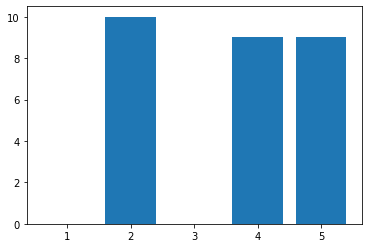

In [588]:
unique_classes = []
for t in teacher_schedule.index:
    unique_classes.append(len(teacher_schedule.loc[t].dropna().unique()))
    
plt.hist(unique_classes, bins=range(1, 7), rwidth=0.8, align='left');

### Secondary schools

#### School types
Next to schools that offer only lower secondary education or upper secondary education, there are schools that offer combined lower and upper secondary education ([ISCED level 2 and 3](https://en.wikipedia.org/wiki/International_Standard_Classification_of_Education)) and teach children aged 11 to 18. There are 281 of these schools (AHS Langform), with 7610 classes and 179633 students. 

#### Daycare
About 50% of these schools offer daycare for children aged 11-14. In all of these schools, about 18% of eligible children are in daycare. Therefore in schools that do offer daycare, on average 36% 

#### Syllabus and teaching personnel
According to the [syllabus of the AHS Oberstufe](https://www.ris.bka.gv.at/GeltendeFassung.wxe?Abfrage=Bundesnormen&Gesetzesnummer=10008568), in these schools students have an average of 32.5 hours / week of lessons at school. In addition, there are a number of non-mandatory tutorials, longer breaks and vocational activities that students engage in. In summary, we model the students to spend 8 hours / day at school. 

The average number of teachers / class for these schools is 2.5. Given the rather low number of teachers available (as compared to 3 teachers / class for schools with only upper secondary education), we do not model lessons with team teaching in these schools.

AHS Unterstufe (18% of children in daycare)

The [syllabus](https://www.ris.bka.gv.at/GeltendeFassung.wxe?Abfrage=Bundesnormen&Gesetzesnummer=10008568) for the AHS Unterstufe is very similar regarding the hours spent at school every week and the number of different subjects.

teachers / class: AHS Unterstufen (2.5)

In [590]:
teachers_AHS = 22537
classes_AHS = 9020 # (including 114 Oberstufenrealgymnasium, 7 Abendschulen and 4 Aufbaugymnasien)
print('AHS Langform teachers / class: {:1.2f}'.format(teachers_AHS / classes_AHS))

AHS Langform teachers / class: 2.50


10

In [674]:
reload(csn)
N_classes = 8


N_hours = 8
N_teachers = csn.get_N_teachers('secondary', N_classes)

teacher_list = list(range(1, int(N_teachers * 2/3) + 1))
teacher_list.extend(list(range(1, int(N_teachers * 2/3) + 1)))
teacher_list.extend(list(range(1, N_teachers + 1)))
teacher_list.extend(list(range(1, int(N_teachers * 1/3) + 1)))
teacher_list.extend(list(range(int(N_teachers * 2/3), N_teachers + 1)))
tmp_list = list(range(1, int(N_teachers * (1/3))))
tmp_list.reverse()
teacher_list.extend(tmp_list)

teacher_list = np.asarray(teacher_list)
teacher_array = teacher_list[0: N_hours * N_classes].reshape((N_hours, N_classes))


first_teacher_schedule = pd.DataFrame(columns=['hour'] + ['class_{}'.format(i) for i in range(1, N_classes + 1)])
first_teacher_schedule['hour'] = [i for i in range(1, N_hours + 1)]
for i in range(0, N_classes):
    first_teacher_schedule['class_{}'.format(i + 1)] = teacher_array[0:,i]

first_teacher_schedule.index = first_teacher_schedule['hour']
first_teacher_schedule = first_teacher_schedule.drop(columns = ['hour'])


teacher_schedule = pd.DataFrame(columns=['teacher'] + ['hour_{}'.format(i) for i in range(1, N_hours + 1)])
teacher_schedule['teacher'] = ['t{}'.format(i) for i in range(1, N_teachers + 1)]
teacher_schedule.index = teacher_schedule['teacher']
teacher_schedule = teacher_schedule.drop(columns=['teacher'])

for c in range(1, N_classes + 1):
    for hour in range(1, N_hours + 1):
        t1 = first_teacher_schedule.loc[hour, 'class_{}'.format(c)]
        teacher_schedule.loc['t{}'.format(t1), 'hour_{}'.format(hour)] = c

# daycare groups for lower secondary classes
age_bracket = age_brackets['secondary']
age_bracket_map = csn.get_age_distribution('secondary', age_bracket, N_classes)
dc_classes = [c for c, age in age_bracket_map.items() if age < 14]
N_daycare_groups = int(len(dc_classes) / 2)
empty_dc_classes = dc_classes[N_daycare_groups:]
full_dc_classes = dc_classes[0:N_daycare_groups]
dc_class_mapping = {empty:full for empty, full in zip(empty_dc_classes, full_dc_classes)}
teacher_schedule[['hour_7', 'hour_8']] = teacher_schedule[['hour_7', 'hour_8']].replace(dc_class_mapping)

In [675]:
dc_class_mapping

{3: 1, 4: 2}

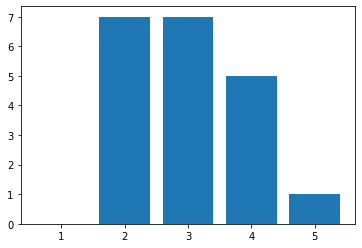

In [664]:
unique_classes = []
for t in teacher_schedule.index:
    unique_classes.append(len(teacher_schedule.loc[t].dropna().unique()))
    
plt.hist(unique_classes, bins=range(1, 7), rwidth=0.8, align='left');

In [733]:
teacher_schedule.head(3)

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8
teacher,,,,,,,,
t1,1,6,NaN,3,NaN,7,NaN,NaN
t2,2,7,NaN,4,NaN,8,NaN,8.0
t3,3,8,NaN,5,NaN,NaN,1.0,7.0


In [770]:
reload(csn)
N_dc_groups = len(dc_classes)
dc_groups = list(range(1, int(N_dc_groups / 2) + 1))
dc_classes = [c for c, age in age_bracket_map.items() if age < 14]
daycare = True
daycare_ratio = 0.38

student_schedule_df_lower_secondary = csn.generate_student_schedule(\
    len(dc_classes), class_size, daycare, daycare_ratio)
student_counter = student_schedule_df_lower_secondary.shape[0]
student_schedule_df_upper_secondary = csn.generate_student_schedule(\
        N_classes - len(dc_classes), class_size, False, daycare_ratio, student_counter)

student_schedule_df = pd.concat([student_schedule_df_lower_secondary,
                              student_schedule_df_upper_secondary])

In [773]:
for hour_col in dc_times:
    for dc_group in dc_groups:
        supervising_teachers = teacher_schedule[\
            teacher_schedule[hour_col] == dc_group].index

        students_in_group = [s for s in student_schedule.index if \
                    not pd.isna(student_schedule.loc[s, 'afternoon']) and \
                    student_schedule.loc[s, 'afternoon'] == dc_group]

        for t in supervising_teachers:
            for s in students_in_group:
                G.add_edge(t, s, link_type='daycare_supervision_teacher_student')

In [748]:
supervising_teachers

Index(['t18', 't20'], dtype='object', name='teacher')

In [750]:
students_in_group

['s2', 's15', 's23', 's30', 's33', 's34', 's39', 's56', 's60', 's73']

In [723]:
dc_times

['hour_7', 'hour_8']